In [4]:
using Distances,LinearAlgebra,StatsBase,Plots

function correlation_dim(xt, upper_dist = 0., lower_dist = 0.)
    dists = pairwise(Euclidean(), xt, xt, dims = 1);
    # Get the lower triangle of the matrix, including the diagonal
    lower_triangle = tril(dists)

    # Now, reshape the lower triangle into a 1D array
    lower_triangle_1D = reshape(lower_triangle, :)

    # Since the reshape operation will also include the upper triangle of the matrix but filled with 0s, you might want to remove those 0s
    lower_triangle_1D = lower_triangle_1D[lower_triangle_1D .!= 0]
    # min_dist = max(minimum(lower_triangle_1D),1e-2)
    if upper_dist > 0
        max_dist = upper_dist
    else
        max_dist = maximum(lower_triangle_1D)
    end
    if lower_dist > 0
        min_dist = lower_dist
    else
        min_dist = sqrt(minimum(lower_triangle_1D)*max_dist/10)
    end
    # epsilons = exp10.(range(log10(min_dist), stop = log10(max_dist), length = 20))
    epsilons = range(min_dist, stop = max_dist, length = 20)
    Ns = []
    for epsilon in epsilons
        push!(Ns, sum(lower_triangle_1D .< epsilon))
    end
    Ns = Ns./(size(dists)[1]*(size(dists)[1]-1))
    return epsilons, Ns
end

function GP_dim(sol, embed_dim = 5, tau = 1; upper_dist = 0., lower_dist = 0.)
    #tau is the nonoverlapping time series interval
    xt = hcat([vcat(sol[:,i*tau:i*tau+embed_dim-1]...) for i in 1:floor(Int,size(sol)[2]/tau)-embed_dim+1]...)'
    epsilons, Ns = correlation_dim(xt,upper_dist, lower_dist)
    return epsilons, Ns
end

GP_dim (generic function with 3 methods)

# Weak chaos data generation

In [2]:
using DifferentialEquations
using Random
using Plots
function Gamma_p(p, p_opt, pc, sig2)
    1 .- (1 .-exp.(-(p .-p_opt).^2 / (2*sig2))) ./ (1 .- exp.(-pc^2 / (2*sig2)))
end

function Beta_p(p, p_opt, pc, sig2)
#     a = 3
#    return (a*exp.(-(p .-p_opt).^2 / (2*sig2)) .- a .+ 1)
    return max.(-5, 1 .- abs.(p.-p_opt)./sig2)
    # return 1 .- abs.(p.-p_opt)./sig2
end

function dn_dt_p(n, p, al, K, p_opt_vec, pc, sig2, lam)
    al * n .* (1 .- sum(n) / K .+ Gamma_p(p, p_opt_vec, pc, sig2)) .+ lam
    # al * n .* (1 .- n / K .+ Beta_p(p, p_opt_vec, pc, sig2)) .+ lam
    # al * n .* (1 .+ Gamma_p(p, p_opt_vec, pc, sig2)) .+ lam
end

function dp_dt(n, p, b1, b2, al, K, p_opt_vec, pc, sig2, fl, S, lam)
    # al/S * sum(b1 .* dn_dt_p(n, p, al, K, p_opt_vec, pc, sig2, lam) .* (dn_dt_p(n, p, al, K, p_opt_vec, pc, sig2, lam) .> 0)) .+ al/S * b2 * sum(n) .- fl * p
    al/S * sum(b1 .* dn_dt_p(n, p, al, K, p_opt_vec, pc, sig2, lam) .* (dn_dt_p(n, p, al, K, p_opt_vec, pc, sig2, lam) .> 0)) + al/S * sum(b2 .* n) .- fl * p
end


dp_dt (generic function with 1 method)

In [3]:
Random.seed!(13)
p_opt_vec = -1:0.5:1 
S = length(p_opt_vec)
p_opt_vec = p_opt_vec #.+ randn(S)*0.1
# b1 = 20*(rand(S) .- 1/2)
b1 = zeros(S)
# b2 = randn(S)*3
# b2 = zeros(S)
b2 = [5. for i in 1:S]
b2[end] = - 12
b2[end-1] = 2
b2[end-2] = 0.1
# b2 = [0.2, 1, -1] 

pc = 0.6
sig2 = 1
# sig2=0.4
K = 2
al = 20
fl = 1*0.1
# p_opt_vec = randn(S)*2
# p_opt_vec = -rand(S).*sign.(b2)
# p_opt_vec = [-1, 0, 1]*0.3 #+ randn(S)*0.1

# lam = 0.
lam = 1e-4

    

function dnp_dt!(dnp, np, p, t)
    dnp[1:S] = dn_dt_p(np[1:S], np[S+1], al, K, p_opt_vec, pc, sig2, lam) 
    dnp[S+1] = dp_dt(np[1:S], np[S+1], b1, b2, al, K, p_opt_vec, pc, sig2, fl, S,lam)
end

# S = 60
# n0 = rand(S)*0.1
n0 = zeros(S)
n0[1] = 1
# n0 = rand(S)
# n0 /= sum(n0) * 0.5
# n0 = [1, 0, 0]
np0 = [n0; 0]
# n0[13] += 2

tspan = (0.0, 300.0)
prob = ODEProblem(dnp_dt!, np0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-12, abstol=1e-12, saveat = 0.01);
leading_species = [argmax(sol[1:S, i]) for i in 1:length(sol.t)];


┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


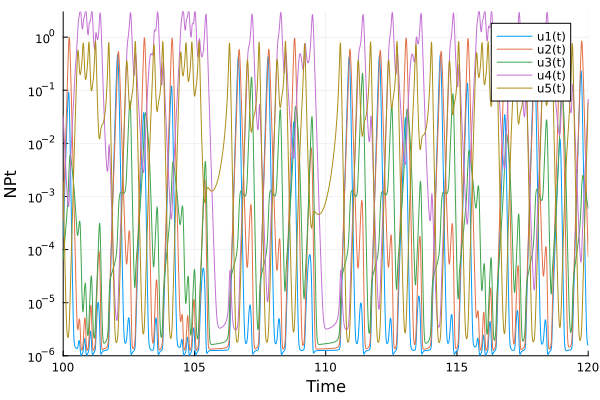

In [4]:
plot(sol, vars = 1:S, xlabel = "Time", ylabel = "NPt")
# plot!(sol, vars = S+1, label = "p", linewidth = 1, color = :black)
plot!(xlim=(100,120),yscale=:log10,ylim=(1e-6,3))
# plot!(yscale=:log10,ylim=(1e-3,1))

# calculate the GP dimension

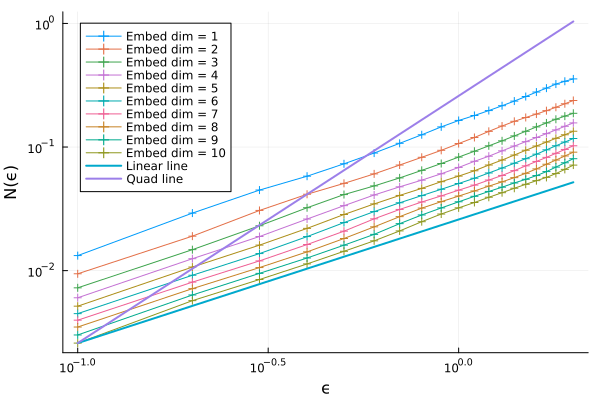

In [5]:
upper_dist = 2
lower_dist = 0.1
tau = 10
epsilons,Ns = GP_dim(sol[:,10000:20000],1,tau,upper_dist = upper_dist , lower_dist = lower_dist);
plot(epsilons,Ns, xlabel = "ϵ", ylabel="N(ϵ)", label="Embed dim = 1", marker=:cross)
for embed_dim in 2:10
    epsilons,Ns = GP_dim(sol[:,10000:20000],embed_dim,tau,upper_dist = upper_dist , lower_dist = lower_dist);
    plot!(epsilons,Ns, label="Embed dim = $embed_dim", marker=:cross)
end
plot!(epsilons,epsilons*Ns[1]/epsilons[1],yscale=:log10,xscale=:log10,label="Linear line",lw=2)
plot!(epsilons,epsilons.^2*Ns[1]/epsilons[1]^2,yscale=:log10,xscale=:log10,label="Quad line",lw=2,legend=:topleft)
# plot!(epsilons,epsilons*Ns[2]/(length(lorenz_sol)^2)/epsilons[2],yscale=:log10,xscale=:log10,label="Linear line")
# plot!(epsilons,epsilons.^2*Ns[2]/(length(lorenz_sol)^2)/(epsilons[2].^2),yscale=:log10,xscale=:log10,label="Quadratic line")
# plot!(xscale=:log10,yscale=:log10,ylim=(minimum(Ns),maximum(Ns)),xlim=(minimum(epsilons),maximum(epsilons)),label="Linear line")

In [10]:
using Polynomials
coeff = Polynomials.fit(log10.(epsilons[Ns.>0]), log10.(Ns[Ns.>0]), 1)

Polynomial(-1.4953351640808104 + 1.0998435996166314*x)

In [13]:
dim = coeff[1]

1.0998435996166314

## test for random variables

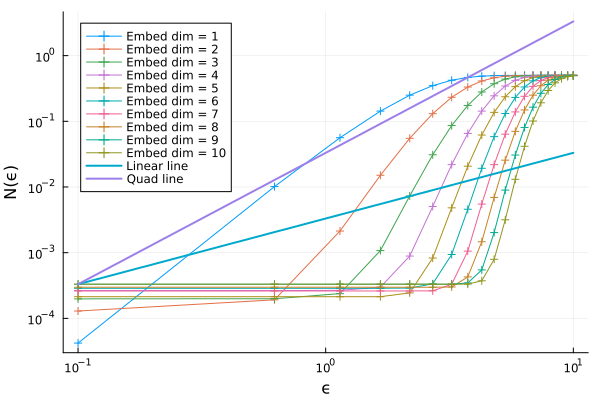

In [7]:
random_sol = randn(3,10000)
upper_dist = 10
lower_dist = 0.1
tau = 10
random_epsilons, random_Ns = GP_dim(random_sol,1,tau,upper_dist = upper_dist , lower_dist = lower_dist);
plot(random_epsilons,random_Ns, xlabel = "ϵ", ylabel="N(ϵ)", label="Embed dim = 1", marker=:cross)
for embed_dim in 2:10
    random_epsilons, random_Ns = GP_dim(random_sol,embed_dim,tau,upper_dist = upper_dist , lower_dist = lower_dist);
    plot!(random_epsilons,random_Ns, label="Embed dim = $embed_dim", marker=:cross)
end
plot!(random_epsilons,random_epsilons*random_Ns[1]/random_epsilons[1],yscale=:log10,xscale=:log10,label="Linear line",lw=2)
plot!(random_epsilons,random_epsilons.^2*random_Ns[1]/random_epsilons[1]^2,yscale=:log10,xscale=:log10,label="Quad line",lw=2,legend=:topleft)